In [1]:
import os
import sys
import argparse
import logging
import torch
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from scipy.stats import multivariate_normal

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [4]:
from nnest import NestedSampler, MCMCSampler
from nnest.trainer import Trainer
from nnest.likelihoods import *
from nnest.priors import *
from nnest.distributions import GeneralisedNormal

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
def plot_flow(samples, model):
    x_synth = model.netG.sample(samples.size).detach().cpu().numpy()
    z = model.get_latent_samples(samples)
    grid = []
    for x in np.linspace(np.min(samples[:, 0]) - 1, np.max(samples[:, 0]) + 1, 10):
        for y in np.linspace(np.min(samples[:, 1]) - 1, np.max(samples[:, 1]) + 1, 5000):
            grid.append([x, y])
    for y in np.linspace(np.min(samples[:, 1]) - 1, np.max(samples[:, 1]) + 1, 10):
        for x in np.linspace(np.min(samples[:, 0]) - 1, np.max(samples[:, 0]) + 1, 5000):
            grid.append([x, y])
    grid = np.array(grid)
    z_grid = model.get_latent_samples(grid)
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].scatter(grid[:, 0], grid[:, 1], c=grid[:, 0], marker='.', s=1, linewidths=0)
    ax[0].scatter(samples[:, 0], samples[:, 1], s=4)
    ax[0].set_title('Real data')
    ax[1].scatter(z_grid[:, 0], z_grid[:, 1], c=grid[:, 0], marker='.', s=1, linewidths=0)
    ax[1].scatter(z[:, 0], z[:, 1], s=4)
    ax[1].set_title('Latent data')
    ax[2].scatter(x_synth[:, 0], x_synth[:, 1], s=2)
    ax[2].set_title('Synthetic data')
    plt.tight_layout()
    plt.show()
    # Plot grid warp
    plt.figure(figsize=(6,6))
    ng = 30
    xx, yy = np.linspace(-4,4, ng), np.linspace(-4,4, ng)
    xv, yv = np.meshgrid(xx, yy)
    xy = np.stack([xv, yv], axis=-1)
    in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3
    xy = xy.reshape((ng*ng, 2))
    xy = torch.from_numpy(xy.astype(np.float32))
    xs = model.get_samples(xy)
    xs = xs.reshape((ng, ng, 2))
    p1 = np.reshape(xs[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(xs[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    p1 = np.reshape(xs[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(xs[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    plt.gca().add_collection(lcy)
    plt.gca().add_collection(lcx)
    plt.xlim([np.min(samples[:,0])-0.05,np.max(samples[:,0])+0.05])
    plt.ylim([np.min(samples[:,1])-0.05,np.max(samples[:,1])+0.05])
    plt.scatter(samples[:,0], samples[:,1], c='r', s=5, alpha=0.5)
    plt.show()

In [7]:
def test_mcmc(like, prior, model, nwalkers=40, init_chain=True, nested_samples=True, mcmc_steps=100, nested_fraction=0.01):
    np.random.seed(0)
    if nested_samples:
        init_samples, loglstar = like.uniform_sample(prior, 1000, nested_fraction)
    else:
        init_samples = like.sample(prior, 1000)
        loglstar = None
    model.train(init_samples, jitter=0.01, max_iters=2000)
    plot_flow(init_samples, model)
    sampler = MCMCSampler(like.x_dim, like, prior=prior, trainer=model, log_level=logging.INFO)
    if init_chain:
        results = sampler._ensemble_sample(mcmc_steps, nwalkers, init_state=init_samples[0:nwalkers, :], 
                                           loglstar=loglstar, stats_interval=1)
    else:
        results = sampler._ensemble_sample(mcmc_steps, nwalkers, loglstar=loglstar, stats_interval=1)
    samples, latent_samples, derived_samples, loglikes, ncall, state = results
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    flat_samples = samples.reshape((-1, like.x_dim))
    flat_latent_samples = latent_samples.reshape((-1, like.x_dim))
    ax[0].scatter(flat_samples[:,0], flat_samples[:,1], c='r', s=5, alpha=0.5)
    ax[1].scatter(flat_latent_samples[:,0], flat_latent_samples[:,1], c='r', s=5, alpha=0.5)
    plt.show()
    fig, ax = plt.subplots(like.x_dim, 2, figsize=(10, like.x_dim))
    for i in range(like.x_dim):
        ax[i, 0].plot(samples[0,0:1000,i])
        ax[i, 1].plot(latent_samples[0,0:1000,i])
    plt.show()
    mc = MCSamples(samples=[samples[i, :, :].squeeze() for i in range(samples.shape[0])], 
                   loglikes=[-loglikes[i, :].squeeze() for i in range(loglikes.shape[0])])
    try:
        print(mc.getEffectiveSamples())
    except:
        pass
    print(ncall)

In [8]:
nwalkers = 100

In [9]:
prior = UniformPrior(2, -15, 15)
like = Eggbox(2)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

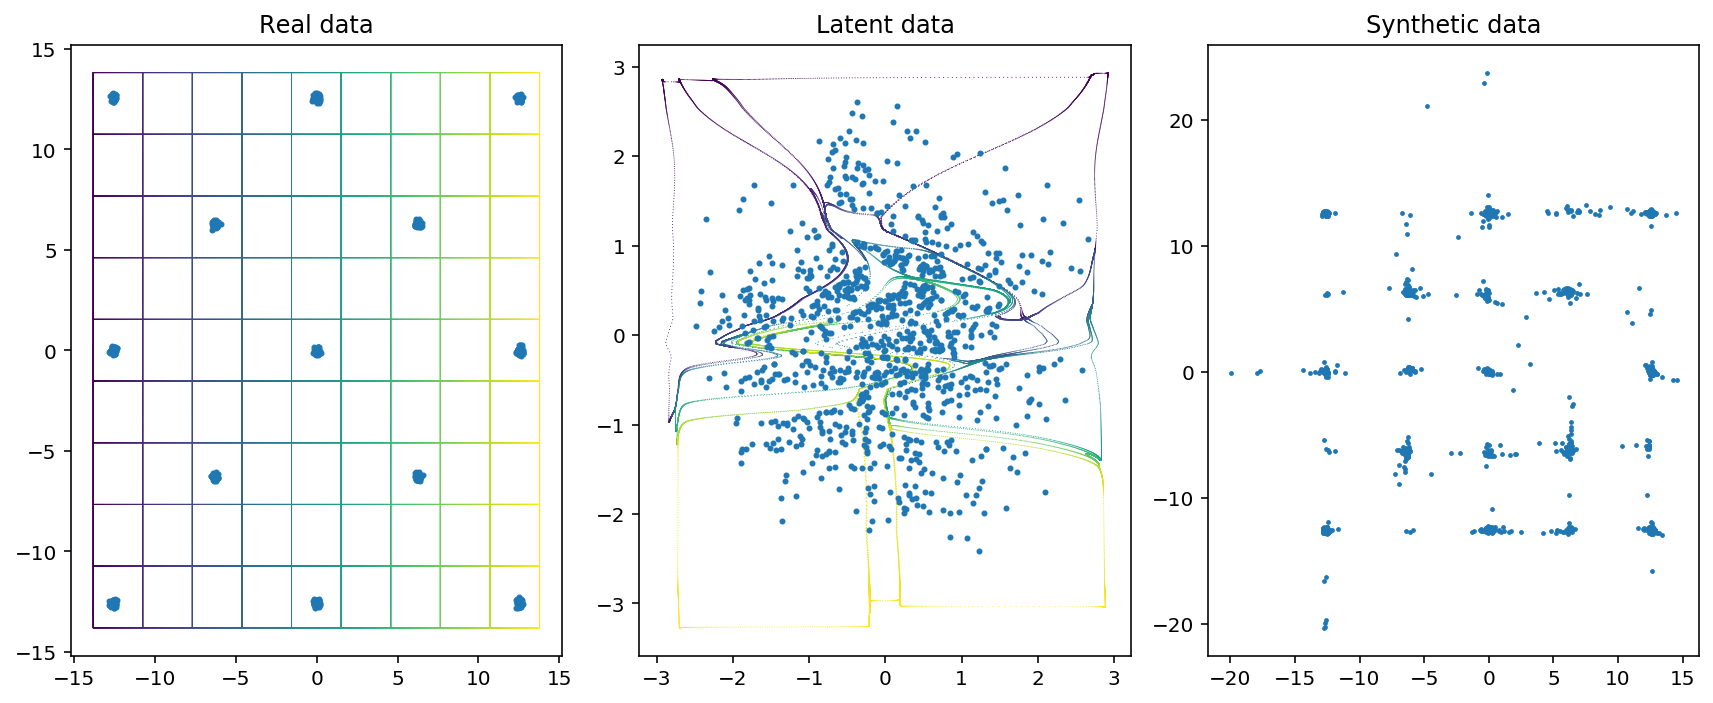

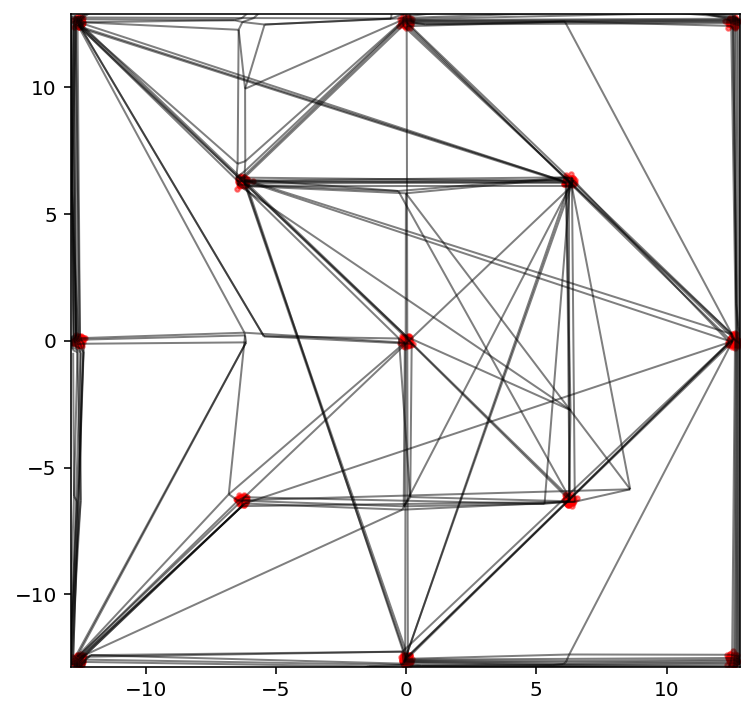

Creating directory for new run logs/test/run6
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]


/Users/adammoss/opt/anaconda3/envs/nnest/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


[nnest.sampler] [INFO] Step [1] acceptance [0.5600] ncalls [100]
[nnest.sampler] [INFO] Step [2] acceptance [0.5600] ncalls [200]
[nnest.sampler] [INFO] Step [3] acceptance [0.5433] ncalls [300]
[nnest.sampler] [INFO] Step [4] acceptance [0.5450] ncalls [400]
[nnest.sampler] [INFO] Step [5] acceptance [0.5480] ncalls [500]
[nnest.sampler] [INFO] Step [6] acceptance [0.5317] ncalls [600]
[nnest.sampler] [INFO] Step [7] acceptance [0.5300] ncalls [700]
[nnest.sampler] [INFO] Step [8] acceptance [0.5225] ncalls [800]
[nnest.sampler] [INFO] Step [9] acceptance [0.5156] ncalls [900]
[nnest.sampler] [INFO] Step [10] acceptance [0.5100] ncalls [1000]
[nnest.sampler] [INFO] Step [11] acceptance [0.5073] ncalls [1100]
[nnest.sampler] [INFO] Step [12] acceptance [0.5050] ncalls [1200]
[nnest.sampler] [INFO] Step [13] acceptance [0.5085] ncalls [1300]
[nnest.sampler] [INFO] Step [14] acceptance [0.5043] ncalls [1400]
[nnest.sampler] [INFO] Step [15] acceptance [0.5040] ncalls [1500]
[nnest.sample

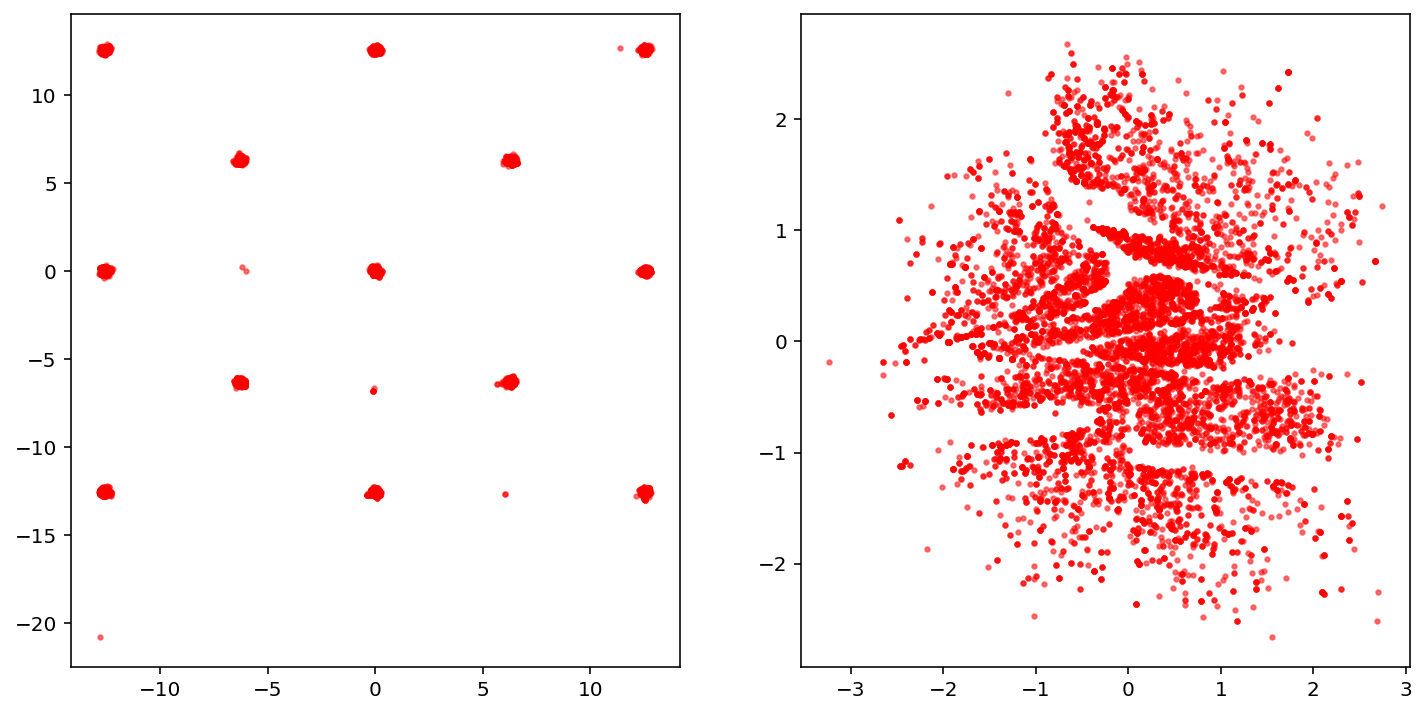

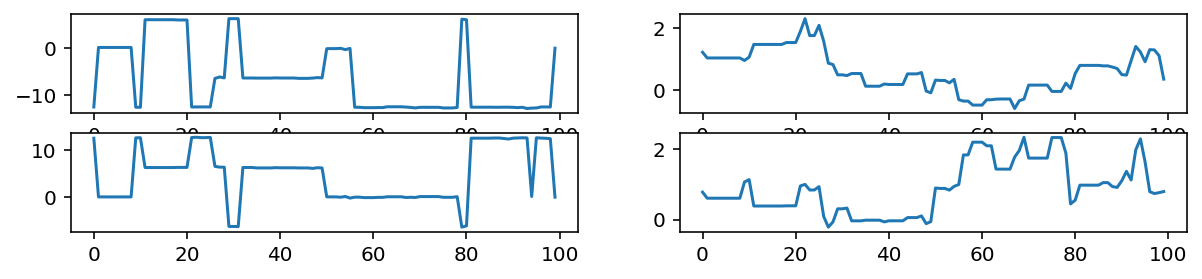

Removed no burn in
411.638347114678
10000


In [10]:
model = Trainer(like.x_dim, flow='spline', learning_rate=0.001)
test_mcmc(like, prior, model, init_chain=False, nwalkers=nwalkers, nested_samples=False)